# Brain Tumor Detection
In this project I am using the kaggle data set with MRI images of brain tumors (https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) to develop a CNN model to detect brain tumors in MRI images. In the data directory, there are two subdirectories: yes (images with tumor) and no (images of normal brain). This dataset has only 253 images, but our model achieves 92% accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'svg'

### Data Directory

In [3]:
path = "/Users/aneesh/Documents/Kaggle/brain tumor/archive/brain_tumor_dataset/"

### Load the images into tensorflow dataset
This code will load all images from all the subdirectories and label them (class = sub directory). It returns training and validation sets (0.8:0.2) in the tensorflow dataset format. Images are batched into size of 16 and resized to 224x224 (this is the input size for Xception)

In [4]:
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  class_names=['no', 'yes'],
  validation_split=0.2,
  subset="both",
  label_mode='binary',
  color_mode='rgb',
  seed=123,
  batch_size=16,
  image_size=(224, 224),
  shuffle=True,
#   data_format='channel_last'
  )

Found 253 files belonging to 2 classes.
Using 203 files for training.
Using 50 files for validation.


2024-01-31 01:22:56.800547: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-31 01:22:56.800581: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-31 01:22:56.800590: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-31 01:22:56.800790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-31 01:22:56.801142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Make sure data has been properly loaded as batches

In [5]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16, 1)


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

## Plot random images from each category

no


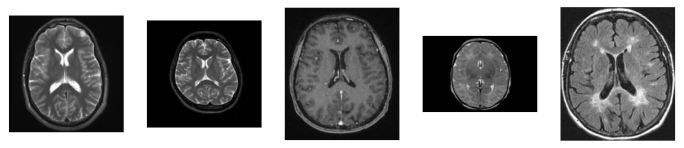

yes


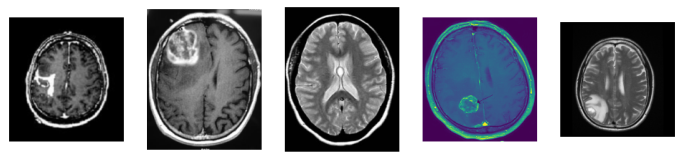

In [18]:
import os
class_names = train_ds.class_names
num_images_per_class = 5
for x in class_names:
    print(x)
    subpath = path + '/' + x
    files = os.listdir(subpath)
    indexes = np.random.randint(0, len(files), num_images_per_class)
    fig, ax = plt.subplots(1, num_images_per_class, figsize=(12, 10))
    for i, idx in enumerate(indexes):
        img = plt.imread(subpath + '/' + files[idx])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

#### I am using the pretrained model Xception
First send the images through the preprocessing pipeline of the Xception

In [7]:
def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(image) 
    return final_image, label

In [8]:
training_ds = train_ds.map(preprocess).prefetch(1)
validation_ds = valid_ds.map(preprocess).prefetch(1)

## Define the Model
Here we load the pretrained Xception architecture and remove its top layers. Then we add a global average pooling layer and then a dense layer. We will train only the top 15 layers of the base model and the dense layer.  Note that the dense layer should have n_classes number of neurons. Sigmoid activation function is used because its binary classification

In [9]:
n_classes = 1
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
output = tf.keras.layers.Dense(n_classes, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

### Early stopping condition
This is to stop training when the validation loss has hit a minimum.
The second part is for saving checkpoints

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
)

### Optimizer
I am using the adam optimizer with a low learning rate to avoid ruining the pretrained layers. 'binary_crossentropy' is used because its binary classification

In [12]:
# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.0005, momentum=0.9, decay=0.01)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(training_ds, epochs=150, validation_data=validation_ds, callbacks=[early_stopping])

Epoch 1/150


2024-01-31 01:22:59.181121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 253ms/step - loss: 0.5668 - accuracy: 0.7241 - val_loss: 0.4329 - val_accuracy: 0.8200
Epoch 2/150
13/13 [==============================] - 2s 130ms/step - loss: 0.2754 - accuracy: 0.9507 - val_loss: 0.4159 - val_accuracy: 0.8000
Epoch 3/150
13/13 [==============================] - 2s 129ms/step - loss: 0.1703 - accuracy: 0.9507 - val_loss: 0.3830 - val_accuracy: 0.8200
Epoch 4/150
13/13 [==============================] - 2s 119ms/step - loss: 0.1030 - accuracy: 0.9704 - val_loss: 0.4489 - val_accuracy: 0.8200
Epoch 5/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0910 - accuracy: 0.9803 - val_loss: 0.4022 - val_accuracy: 0.8600
Epoch 6/150
13/13 [==============================] - 2s 122ms/step - loss: 0.0405 - accuracy: 0.9951 - val_loss: 0.4416 - val_accuracy: 0.8600
Epoch 7/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0283 - accuracy: 0.9951 - val_loss: 0.3999 - val_accuracy: 0.8800
Epoch 8/150

## Plot accuracy evolution
We can see that the model has saturated at around ~10 epochs

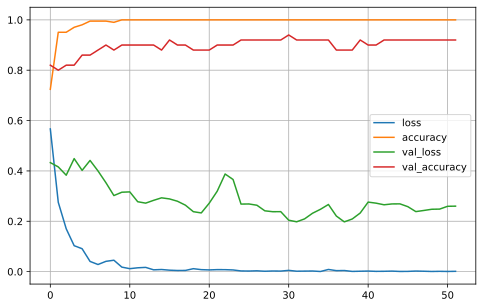

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
# plt.gca().set_ylim(0, 1.0)

### Print the best validation accuracy

In [16]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

4/4 [==============================] - 0s 62ms/step - loss: 0.1979 - accuracy: 0.9200
Validation Accuracy: 92.00%


### Check the number of correctly classified images in the validation set

In [17]:
prediction = model.predict(validation_ds)
predicted_classes = (prediction > 0.5).astype("int32")
# get labels from validation_ds
validation_labels = []
for images, labels in validation_ds:
    validation_labels.append(labels.numpy())
validation_labels = np.concatenate(validation_labels)
correct_labels = [np.argmax(i) for i in validation_labels]
accuracy = (predicted_classes == validation_labels).mean()
print('Fraction of correctly classified images = ', accuracy)

4/4 [==============================] - 0s 91ms/step
Fraction of correctly classified images =  0.92


## Our model has achieved a 92 % accuracy with such a small training dataset!!
#### In the __[_brain_tumor_classification_](https://github.com/aneeshsvn/DeepLearning_and_ComputerVision/tree/main/Brain_tumor_classification)__ project I test this architecture on a different dataset (larger) where we classify tumors into 4 categories